In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plants-type-datasets' dataset.
Path to dataset files: /kaggle/input/plants-type-datasets


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [53]:
class Plants(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.Sample = []
        class_names = sorted(os.listdir(root_dir))

        self.class_to_idx = {cls: i for i, cls in enumerate(class_names)}

        for cls in class_names:
            class_dir = os.path.join(root_dir, cls)
            label = self.class_to_idx[cls]

            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.Sample.append((img_path, label))

    def __len__(self):
        return len(self.Sample)

    def __getitem__(self, idx):
        img_path, label = self.Sample[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [8]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

print("Mean:", mean)
print("Std:", std)

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert to tensor first
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    # Add tensor-based augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),#Changeing the size of the imge so the cde be faster
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean) , torch.Tensor(std))

])


In [ ]:
train_dataset = Plants(
    root_dir=f"{BASE}/Train_Set_Folder",
    transform=train_transform
)


test_dataset = Plants(
    root_dir=f"{BASE}/Test_Set_Folder",
    transform=test_transform
)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_transformed_images(dataset, batch_size=9):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )

    images, labels = next(iter(loader))

    grid = torchvision.utils.make_grid(images, nrow=3)

    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")

    print("Labels:", labels)


Labels: tensor([16, 22, 17, 14, 29,  7,  4, 21, 11])


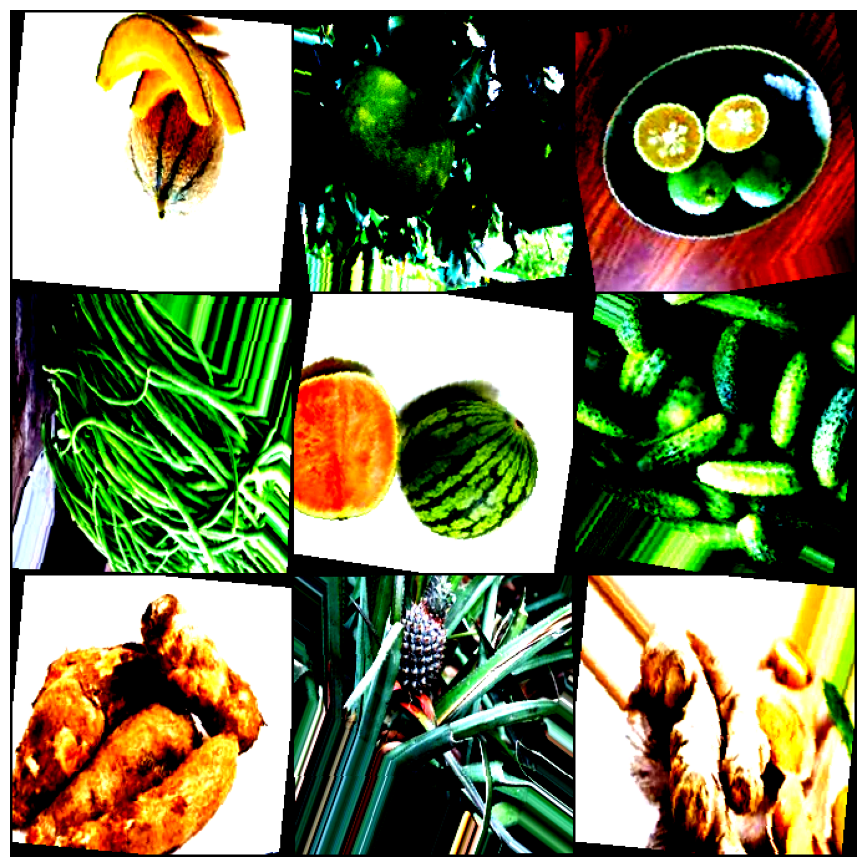

In [12]:
show_transformed_images(train_data)

In [13]:
image, label = train_data[0]
print(image.shape, label)
print("length of train dataset", len(train_data))
print("length of test dataset", len(test_data))


torch.Size([3, 224, 224]) 0
length of train dataset 23972
length of test dataset 2998


In [14]:
class CNN_Plant(nn.Module):

  def __init__(self,num_classes):
    super(CNN_Plant,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,out_channels=32 , kernel_size=3 , padding = 1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()


    self.fc1 = nn.Linear(100352, 512)
    self.relu4 = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self,x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)


        return x


In [15]:
num_classes = len(train_data.class_to_idx)
print(num_classes)

model = CNN_Plant(num_classes)

30


In [16]:
print(type(model))
print(model)

<class '__main__.CNN_Plant'>
CNN_Plant(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
)


In [17]:
loss_function = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def training_loop(model, train_loader, loss_function, optimizer, num_epoch, device):
    model.to(device)
    train_losses = []

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)


        if (epoch + 1) % 2 == 0:
            print(f"Epoch [{epoch+1}/{num_epoch}] - Loss: {epoch_loss:.4f}")


    return model, train_losses

In [20]:
def test_loop(model, test_loader, loss_function, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f" Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    return avg_loss, accuracy


In [22]:
test_loss, test_acc = test_loop(
    model=model,
    test_loader=test_loader,
    loss_function=loss_function,
    device=device
)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same